{'n_cars': 8792, 'data_type': dtype('float32'), 'image_shape': (64, 64, 3), 'n_notcars': 9666}


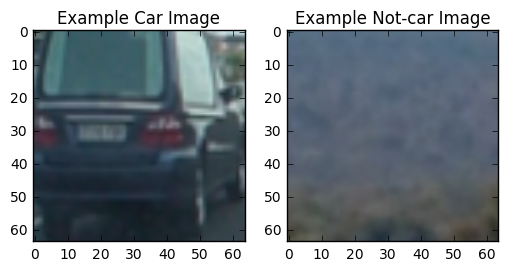

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn import svm
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline

cars = []
notcars = []

images_nonveh = glob.glob('non-vehicles/*/*.png')
images_veh = glob.glob('vehicles/*/*.png')
for image in images_nonveh:

    notcars.append(image)
    
for image in images_veh:
    cars.append(image)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)
print(data_info)
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [10]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    
    color1 = cv2.resize(img[: , : , 0], size).ravel()
    color2 = cv2.resize(img[: , : , 1], size).ravel()
    color3 = cv2.resize(img[: , : , 2], size).ravel()
    # Use cv2.resize().ravel() to create the feature vector
    # Return the feature vector
    return np.hstack((color1,color2,color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
   
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32,32),
                                     hist_bins=32,orient=9, 
                                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                                    spatial_feat=True,hist_feat=True,hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features= []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image,size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            hist_features = color_hist(feature_image,nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:

        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True,thresh=0.70):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
       
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        dec_threshold=thresh
        dec = clf.decision_function(test_features)
        prediction = int(dec > dec_threshold)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] =  np.int(img.shape[0]/2)
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims<3:
            plt.imshow(img,cmap="hot")
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])






In [159]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#project_video ,pj2 is HSV
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
#y_start_stop = [image.shape[0]//2,image.shape[0]]


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print(np.shape(X))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.001)
#svc = svm.SVC(kernel = "rbf")
#rfc = RandomForestClassifier()
#eclf = VotingClassifier(estimators=[
#         ('svc', svc), ('rfc', rfc)], voting='hard')


# Check the training time for the SVC
t=time.time()

svc.fit(X_train, y_train)
#eclf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
#print('Test Accuracy of SVC = ', round(eclf.score(X_test, y_test), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()

(18458, 5520)
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5520
14.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9935


1924


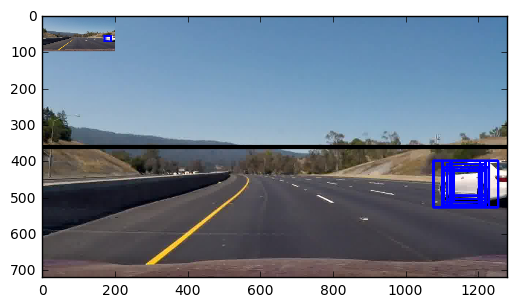

In [160]:
image = mpimg.imread('test/0220.jpg')
draw_image = np.copy(image)
y_start_stop =[400,656]
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows1 = slide_window(image, x_start_stop=[600, None], y_start_stop=[400,500], 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))
windows2 = slide_window(image, x_start_stop=[600, None], y_start_stop=[400,600], 
                    xy_window=(96, 96), xy_overlap=(0.9, 0.9))
windows3 = slide_window(image, x_start_stop=[600, None], y_start_stop=[400,650], 
                    xy_window=(128, 128), xy_overlap=(0.8, 0.8))

windows = windows1+windows2+windows3
print(len(windows))
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,thresh=0.20)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)      
#print(np.shape(window_img))
window_img[0:100,0:200,:]=cv2.resize(window_img,(200,100))
plt.imshow(window_img)
plt.hlines(y=360,xmin=0,xmax=1280,lw=3)

In [161]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
    
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)> 30) & (np.max(nonzerox)-np.min(nonzerox)> 30)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            print("Car Number,",car_number,"Middle X",(bbox[0][0]+bbox[1][0])//2,"Middle Y",(bbox[0][1]+bbox[1][1])//2)
        # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img




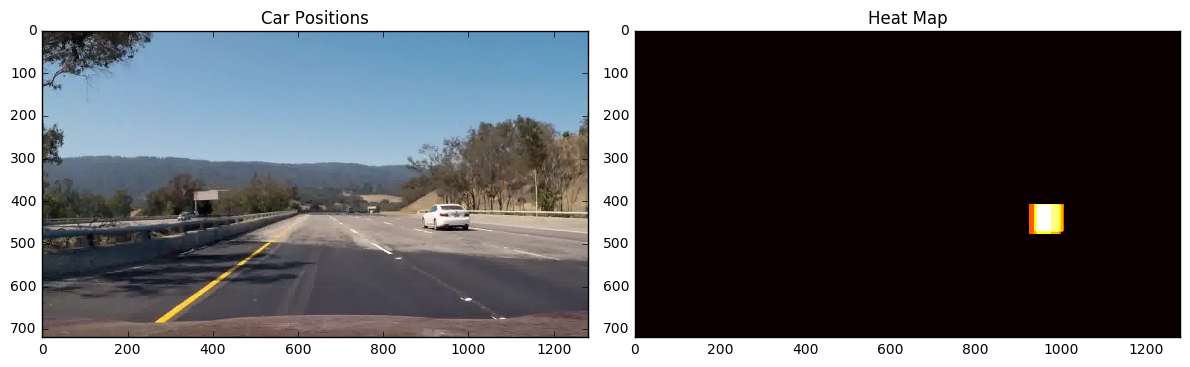

In [ ]:
def pipeline(img):
    # Read in a pickle file with bboxes saved
    # Each item in the "all_bboxes" list will contain a 
    # list of boxes for one of the images shown above
    #box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

    # Read in image similar to one shown above 
    image = img.astype(np.float32)/255
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    windows1 = slide_window(image, x_start_stop=[800, 1200], y_start_stop=[400,480], 
                    xy_window=(64, 64), xy_overlap=(0.91, 0.91))
    windows5 = slide_window(image, x_start_stop=[1000, 1200], y_start_stop=[390,500], 
                    xy_window=(70, 70), xy_overlap=(0.90, 0.90))
    windows2 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,500], 
                    xy_window=(90, 90), xy_overlap=(0.91, 0.91))
    windows3 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,600], 
                    xy_window=(100, 100), xy_overlap=(0.8, 0.8))
    windows4 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,600], 
                    xy_window=(110, 110), xy_overlap=(0.8, 0.8))

    windows = windows1+windows2+windows3+windows4+windows5
    #print(len(windows))
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat,thresh=0.8)               
    box_list= hot_windows

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3.0)
    #project_output 1.0
    #project_output2 
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels= label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    
    #plt.imshow(draw_img)
   # return draw_img ,heatmap
    return draw_img
img = mpimg.imread('test/0654.jpg')
#draw_img,heatmap = pipeline(img) 
draw_img = pipeline(img) 

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(draw_img)
#plt.scatter(847,471,s=100)

plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [210]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'test_short.mp4'

clip_project = VideoFileClip("test_video.mp4")
project_clip = clip_project.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

3229
Car Number, 1 Middle X 872 Middle Y 452
Car Number, 2 Middle X 1047 Middle Y 452
[MoviePy] >>>> Building video test_short.mp4
[MoviePy] Writing video test_short.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

3229


  3%|▎         | 1/39 [00:15<10:02, 15.85s/it]

Car Number, 1 Middle X 872 Middle Y 452
Car Number, 2 Middle X 1047 Middle Y 452
3229


  5%|▌         | 2/39 [00:30<09:32, 15.47s/it]

Car Number, 1 Middle X 876 Middle Y 452
Car Number, 2 Middle X 1047 Middle Y 454
3229


  8%|▊         | 3/39 [00:50<10:04, 16.78s/it]

Car Number, 1 Middle X 876 Middle Y 452
Car Number, 2 Middle X 1049 Middle Y 454
3229


 10%|█         | 4/39 [01:11<10:34, 18.13s/it]

Car Number, 1 Middle X 872 Middle Y 449
Car Number, 2 Middle X 1054 Middle Y 453
3229


 13%|█▎        | 5/39 [01:30<10:29, 18.52s/it]

Car Number, 1 Middle X 872 Middle Y 452
Car Number, 2 Middle X 1054 Middle Y 452
3229


 15%|█▌        | 6/39 [01:46<09:44, 17.70s/it]

Car Number, 1 Middle X 880 Middle Y 452
Car Number, 2 Middle X 1055 Middle Y 452
3229


 18%|█▊        | 7/39 [02:03<09:14, 17.32s/it]

Car Number, 1 Middle X 876 Middle Y 452
Car Number, 2 Middle X 1055 Middle Y 454
3229


 21%|██        | 8/39 [02:17<08:29, 16.44s/it]

Car Number, 1 Middle X 884 Middle Y 452
Car Number, 2 Middle X 1057 Middle Y 453
3229


 23%|██▎       | 9/39 [02:33<08:08, 16.28s/it]

Car Number, 1 Middle X 880 Middle Y 452
Car Number, 2 Middle X 1080 Middle Y 453
Car Number, 3 Middle X 1235 Middle Y 508
3229


 26%|██▌       | 10/39 [02:48<07:44, 16.02s/it]

Car Number, 1 Middle X 873 Middle Y 449
Car Number, 2 Middle X 1056 Middle Y 453
Car Number, 3 Middle X 1132 Middle Y 448
Car Number, 4 Middle X 1253 Middle Y 508
3229


 28%|██▊       | 11/39 [03:04<07:27, 15.98s/it]

Car Number, 1 Middle X 881 Middle Y 449
Car Number, 2 Middle X 1060 Middle Y 453
3229


 31%|███       | 12/39 [03:19<06:57, 15.47s/it]

Car Number, 1 Middle X 876 Middle Y 449
Car Number, 2 Middle X 1058 Middle Y 453
3229


 33%|███▎      | 13/39 [03:33<06:34, 15.16s/it]

Car Number, 1 Middle X 883 Middle Y 449
Car Number, 2 Middle X 1059 Middle Y 454
3229


 36%|███▌      | 14/39 [03:48<06:20, 15.21s/it]

Car Number, 1 Middle X 869 Middle Y 452
Car Number, 2 Middle X 1067 Middle Y 452
3229


 38%|███▊      | 15/39 [04:07<06:28, 16.17s/it]

Car Number, 1 Middle X 880 Middle Y 449
Car Number, 2 Middle X 1068 Middle Y 454
3229


 41%|████      | 16/39 [04:26<06:30, 16.97s/it]

Car Number, 1 Middle X 884 Middle Y 449
Car Number, 2 Middle X 1067 Middle Y 456
3229


 44%|████▎     | 17/39 [04:43<06:13, 16.96s/it]

Car Number, 1 Middle X 877 Middle Y 449
Car Number, 2 Middle X 1071 Middle Y 457
3229


 46%|████▌     | 18/39 [04:58<05:44, 16.41s/it]

Car Number, 1 Middle X 871 Middle Y 452
Car Number, 2 Middle X 1068 Middle Y 454
3229


 49%|████▊     | 19/39 [05:11<05:11, 15.55s/it]

Car Number, 1 Middle X 876 Middle Y 454
Car Number, 2 Middle X 1069 Middle Y 454
3229


 51%|█████▏    | 20/39 [05:25<04:44, 15.00s/it]

Car Number, 1 Middle X 891 Middle Y 449
Car Number, 2 Middle X 1072 Middle Y 456
3229


 54%|█████▍    | 21/39 [05:40<04:30, 15.01s/it]

Car Number, 1 Middle X 884 Middle Y 452
Car Number, 2 Middle X 1072 Middle Y 456
3229


 56%|█████▋    | 22/39 [05:54<04:10, 14.75s/it]

Car Number, 1 Middle X 881 Middle Y 449
Car Number, 2 Middle X 1075 Middle Y 454
3229


 59%|█████▉    | 23/39 [06:08<03:52, 14.54s/it]

Car Number, 1 Middle X 883 Middle Y 448
Car Number, 2 Middle X 1081 Middle Y 456
3229


 62%|██████▏   | 24/39 [06:28<04:00, 16.03s/it]

Car Number, 1 Middle X 884 Middle Y 448
Car Number, 2 Middle X 1076 Middle Y 454
3229


 64%|██████▍   | 25/39 [06:43<03:42, 15.88s/it]

Car Number, 1 Middle X 880 Middle Y 452
Car Number, 2 Middle X 1081 Middle Y 456
3229


 67%|██████▋   | 26/39 [07:00<03:30, 16.20s/it]

Car Number, 1 Middle X 883 Middle Y 448
Car Number, 2 Middle X 1086 Middle Y 456
3229


 69%|██████▉   | 27/39 [07:18<03:20, 16.73s/it]

Car Number, 1 Middle X 884 Middle Y 449
Car Number, 2 Middle X 1084 Middle Y 453
3229


 72%|███████▏  | 28/39 [07:34<03:01, 16.54s/it]

Car Number, 1 Middle X 884 Middle Y 448
Car Number, 2 Middle X 1084 Middle Y 460
3229


 74%|███████▍  | 29/39 [07:49<02:38, 15.88s/it]

Car Number, 1 Middle X 887 Middle Y 449
Car Number, 2 Middle X 1108 Middle Y 459
3229


 77%|███████▋  | 30/39 [08:03<02:18, 15.38s/it]

Car Number, 1 Middle X 877 Middle Y 449
Car Number, 2 Middle X 1113 Middle Y 456
3229


 79%|███████▉  | 31/39 [08:17<01:59, 14.93s/it]

Car Number, 1 Middle X 877 Middle Y 452
Car Number, 2 Middle X 1094 Middle Y 450
3229


 82%|████████▏ | 32/39 [08:31<01:42, 14.65s/it]

Car Number, 1 Middle X 877 Middle Y 449
Car Number, 2 Middle X 1094 Middle Y 449
3229


 85%|████████▍ | 33/39 [08:45<01:26, 14.49s/it]

Car Number, 1 Middle X 882 Middle Y 454
Car Number, 2 Middle X 1094 Middle Y 450
3229


 87%|████████▋ | 34/39 [08:59<01:12, 14.44s/it]

Car Number, 1 Middle X 880 Middle Y 456
Car Number, 2 Middle X 1120 Middle Y 452
3229


 90%|████████▉ | 35/39 [09:13<00:57, 14.33s/it]

Car Number, 1 Middle X 880 Middle Y 456
Car Number, 2 Middle X 1117 Middle Y 453
3229


 92%|█████████▏| 36/39 [09:27<00:42, 14.30s/it]

Car Number, 1 Middle X 876 Middle Y 456
Car Number, 2 Middle X 1104 Middle Y 453
3229


 95%|█████████▍| 37/39 [09:42<00:28, 14.49s/it]

Car Number, 1 Middle X 884 Middle Y 456
Car Number, 2 Middle X 1127 Middle Y 454
3229


 97%|█████████▋| 38/39 [09:56<00:14, 14.23s/it]

Car Number, 1 Middle X 881 Middle Y 456
Car Number, 2 Middle X 1129 Middle Y 456


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_short.mp4 

CPU times: user 18min 16s, sys: 11.6 s, total: 18min 28s
Wall time: 9min 57s


In [211]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
project_output = 'project_output4.mp4'

clip_project = VideoFileClip("project_video.mp4")
project_clip = clip_project.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output4.mp4
[MoviePy] Writing video project_output4.mp4


  0%|          | 1/1261 [00:12<4:28:17, 12.78s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))